In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
import  matplotlib.pyplot as plt
import math
import numpy as np


Using TensorFlow backend.


In [0]:


class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [0]:
batch_size = 128
num_classes = 10
epochs = 150


In [0]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
## DEFINE A DATA AUGMENTATION GENERATOR
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range = 15,
    horizontal_flip=True)

###########################################################
# Now this is necessary due to the feature normalization: #
datagen.fit(x_train)
training_generator = MixupGenerator(x_train, y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

###########################################################

In [0]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, (3, 3), padding='same',input_shape=ishape))
    else:
        model.add(Conv2D(filters, (3, 3), padding='same'))
        
    model.add(BN())
    model.add(GN(0.15))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters, (3, 3), padding='same'))    
    model.add(BN())
    model.add(GN(0.15))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    return model

## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()















Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 32, 3

In [0]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 50:
        return .1
    elif epoch < 75:
        return 0.05
    elif epoch < 100:
        return 0.01
    else:
        return 0.001
    
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.9
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    if lrate < 0.001:
        lrate =0.001
    return lrate

set_lr = LRS(scheduler)


## TRAINING with DA and LRA
history=model.fit_generator(generator = datagen.flow(x_train,y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1) 
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]) 

Epoch 1/150
391/390 [==============================] - 31s 79ms/step - loss: 1.8702 - accuracy: 0.3199 - val_loss: 1.9788 - val_accuracy: 0.3113
Epoch 2/150
391/390 [==============================] - 25s 63ms/step - loss: 1.4088 - accuracy: 0.4868 - val_loss: 1.6309 - val_accuracy: 0.4434
Epoch 3/150
391/390 [==============================] - 25s 63ms/step - loss: 1.1966 - accuracy: 0.5716 - val_loss: 1.1159 - val_accuracy: 0.6118
Epoch 4/150
391/390 [==============================] - 25s 63ms/step - loss: 1.0361 - accuracy: 0.6338 - val_loss: 1.0392 - val_accuracy: 0.6484
Epoch 5/150
391/390 [==============================] - 25s 63ms/step - loss: 0.9349 - accuracy: 0.6690 - val_loss: 0.9443 - val_accuracy: 0.6636
Epoch 6/150
391/390 [==============================] - 25s 63ms/step - loss: 0.8519 - accuracy: 0.7007 - val_loss: 1.1261 - val_accuracy: 0.6312
Epoch 7/150
391/390 [==============================] - 25s 63ms/step - loss: 0.7936 - accuracy: 0.7239 - val_loss: 0.8918 - val_ac

In [0]:
def step_decay(epoch):
    initial_lrate = 0.2
    drop = 0.9
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    if lrate < 0.001:
        print("bajo")
        lrate =0.001
    return lrate


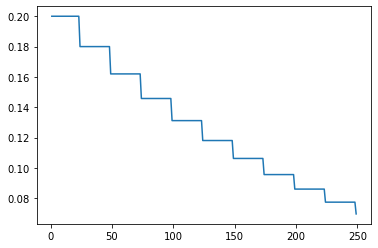

In [0]:
epochs= []
lr = []
for item in range(1,250):
    epochs.append(item)
    lr.append(step_decay(item))
plt.plot(epochs,lr)

In [0]:
from IPython.display import SVG
from keras.utils import plot_model
#Mostrar arquitectura de la red
plot_model(model, to_file='model.png')
import matplotlib.pyplot as plt

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Evolución del la funcion de perdida en train y test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


NameError: ignored